## Train the Yolov4-tiny on a local server

---

### Preprocess requirements
- Cut the target image into slices of 416x416
- Mark the start pos of the slice in its filename
- Generate groundtruth (labels) correspond to each slice
    - If the centre point is in the slice, then mark the object to be in the slice
- Cut with an overlap of 20%

In [1]:
BASE_FOLDER = "/home/mrsail/文档/YOLO-Local/"
IMG_FOLDER = BASE_FOLDER + "4K-IMG/"
TARGET_FOLDER = BASE_FOLDER + "Sliced-4K/"
TEST_FOLDER = BASE_FOLDER + "Sliced-test/"
SLICE = 416
OVERLAP = 0.2
STEP = int(SLICE * (1 - OVERLAP))

from PIL import Image
import sys

### Define how to split the image
- Need to provide the name of the image, without suffix
- Will cut split the images with the preset settings\
- Only keep the slices that have object in it

In [ ]:
def splitImage(imageName, isTrainingSample=False):
    # Read in the image
    image = Image.open(IMG_FOLDER + imageName + ".jpg")
    (img_width, img_height) = image.size
    if isTrainingSample:
        # Read in the groundtruth file
        txt = open(IMG_FOLDER + imageName + ".txt")
        contents = txt.readlines()
        txt.close()
    # Prepare to store the target slices
    slice_list = []
    x_pos = 0
    while x_pos < img_width:
        y_pos = 0
        while y_pos < img_height:
            # when the row of last slice went out of the image
            if x_pos + SLICE > img_width:
                if y_pos + SLICE <= img_height:
                    cur_slice = (img_width - SLICE, y_pos, img_width, y_pos + SLICE)
                # all out of bounds
                else:
                    cur_slice = (img_width - SLICE, img_height - SLICE, img_width, img_height)
            else:
                if y_pos + SLICE <= img_height:
                    cur_slice = (x_pos, y_pos, x_pos + SLICE, y_pos + SLICE)
                # the col went out of the image
                else:
                    cur_slice = (x_pos, img_height - SLICE, x_pos + SLICE, img_height)
            # If not training sample, all slices will be kept (without groundtruth file)
            if not isTrainingSample:
                slice_list.append(cur_slice)
            # Only keep the slices that have target objects
            elif labelSlice(cur_slice, imageName, img_width, img_height, contents):
                slice_list.append(cur_slice)
            y_pos += STEP
        x_pos += STEP
    slices = [image.crop(cur_slice) for cur_slice in slice_list]
    # Save the images
    if not isTrainingSample:
         for idx in range(len(slice_list)):
            slices[idx].save(TEST_FOLDER + imageName + "." + str(slice_list[idx][0]) + "." + str(slice_list[idx][1]) + ".jpg")
    else:
        for idx in range(len(slice_list)):
            slices[idx].save(TARGET_FOLDER + imageName + "." + str(slice_list[idx][0]) + "." + str(slice_list[idx][1]) + ".jpg")

### Check if the slice contains any object
- True: have object(s) in the slice
- If true, the label of the slice will be automatically generated 
    - The format: x_center, y_center, width, height
    - Nomarlised with the size of the slice
    - The width and the height of the bounding box is not changed (no matter if it goes out of the slice)

In [ ]:
def labelSlice(cur_slice, imageName, img_width, img_height, contents):
    selected = (cur_slice[0], cur_slice[1])
    new_label_list = []
    # Find if there exists any object in the slice
    for lab_target in contents:
        target = lab_target.split(' ')
        target[1] = img_width * float(target[1])
        target[2] = img_height * float(target[2])
        target[3] = img_width * float(target[3])
        target[4] = img_height * float(target[4])
        # Check if the center point in the slice
        if selected[0] <= target[1] and target[1] <= selected[0] + SLICE:
            if selected[1] <= target[2] and target[2] <= selected[1] + SLICE:
                # Rewrite the position for the current slice
                new_label = [target[0], 0, 0, 0, 0]
                new_label[1] = (target[1] - selected[0]) / SLICE
                new_label[2] = (target[2] - selected[1]) / SLICE
                new_label[3] = target[3] / SLICE
                new_label[4] = target[4] / SLICE
                new_label_list.append(new_label)
    if len(new_label_list) > 0:
        tar_file = open(TARGET_FOLDER + imageName + "." + str(selected[0]) + "." + str(selected[1]) + ".txt", mode='w')
        for new_label in new_label_list:
            out_str = new_label[0] + " " + str(new_label[1]) + " " + str(new_label[2]) + " " + str(new_label[3]) + " " + str(new_label[4]) + "\n"
            tar_file.write(out_str)
        tar_file.close()
        return True
    else:
        return False

- Here's another slice method:
    - This time we limit the bounding box and not let it go outside of the current slice.

In [ ]:
def labelSlice(cur_slice, imageName, img_width, img_height, contents):
    selected = (cur_slice[0], cur_slice[1])
    new_label_list = []
    # Find if there exists any object in the slice
    for lab_target in contents:
        target = lab_target.split(' ')
        target[1] = img_width * float(target[1])
        target[2] = img_height * float(target[2])
        target[3] = img_width * float(target[3])
        target[4] = img_height * float(target[4])
        # Check if the center point in the slice
        if selected[0] <= target[1] and target[1] <= selected[0] + SLICE:
            if selected[1] <= target[2] and target[2] <= selected[1] + SLICE:
                # Rewrite the position for the current slice
                new_label = [target[0], 0, 0, 0, 0]
                # x and y must be in the current slice
                new_label[1] = (target[1] - selected[0]) / SLICE
                new_label[2] = (target[2] - selected[1]) / SLICE
                # check if it goes out of the box
                if target[1] + (target[3] / 2) > selected[0] + SLICE:
                    new_label[3] = 2 * (selected[0] + SLICE - target[1]) / SLICE
                else:
                    new_label[3] = target[3] / SLICE
                if target[2] +  (target[4] / 2) > selected[1] + SLICE:
                    new_label[4] = 2 * (selected[1] + SLICE - target[2]) / SLICE
                else:
                    new_label[4] = target[4] / SLICE
                new_label_list.append(new_label)
    if len(new_label_list) > 0:
        tar_file = open(TARGET_FOLDER + imageName + "." + str(selected[0]) + "." + str(selected[1]) + ".txt", mode='w')
        for new_label in new_label_list:
            out_str = new_label[0] + " " + str(new_label[1]) + " " + str(new_label[2]) + " " + str(new_label[3]) + " " + str(new_label[4]) + "\n"
            tar_file.write(out_str)
        tar_file.close()
        return True
    else:
        return False

### How to use
- Change the presettings corresponding to ur special requirements
- Create a .txt file to mark all the images you want to split
- Use a loop to call the splitImage Method
    - If it is training data (already labeled with YOLO format), set `isTrainingSample` to be `True`
    - Else leave it blank, all the slices will be kept for testing

### Example: 
- Preprocess some image to train on a tiny-yolov4 network

In [ ]:
# Attention: XY wrong naming files, YF not submitted, ZY & JH wrong class numbers
# labelled images from 25~112, 152~180 can be used
image_list = ['31','42','47','59','69','72','78','83','87','152','156','162','169','168','167','171','175']
# Each station is taken 10 images with different sunlight state and angle, thus we do not really need to do the data augmentation
for image_name in image_list:
  for i in range(1,11):
    cur_image_name = image_name + ("." + str(i))
    try:
      splitImage(imageName=cur_image_name, isTrainingSample=True)
    except FileNotFoundError:
      print("File not found: " + cur_image_name)
      continue

- Now we create the `train.txt` and `test.txt` file to describe the training and validating samples.
- This time we keep the selection process really simple, which should not be in real big projects.

In [ ]:
import os

# Read out all the images under the target dir.
img_list = []
test_img_list = []
for root, dirs, files in os.walk(TARGET_FOLDER):
  for file in files:
    if os.path.splitext(file)[1] == '.jpg':
      img_list.append(file)
      if os.path.splitext(file)[0].split('.')[1] == '4':
        test_img_list.append(file)

# Select some of them as training samples
train_txt = open(BASE_FOLDER + "YOLOv4-Config/train.txt", mode='w')
for slice in img_list:
  train_txt.write(TARGET_FOLDER + slice + '\n')
train_txt.close()

# Also, the validation samples.
test_txt = open(BASE_FOLDER + "/YOLOv4-Config/test.txt", mode='w')
for slice in test_img_list:
  test_txt.write(TARGET_FOLDER + slice + '\n')
test_txt.close()

print("Done. The .txt files should be found at: %s" % (BASE_FOLDER + "YOLOv4-Config"))

- This time we can start to train a Yolov4-tiny network, but before that we need to write some configuration files:<br>
`obj.data`: Describe where the training and testing samples are, also, tell our model how many classes we have and which are they.<br>
`obj.names`: Tell the network the name of each class.<br>
`yolov4-tiny-obj.cfg`: Describe the training parameters and the network architecture.<br>
`yolov4-tiny.conv.29`: Our pretrained weight file, which remove the learnt parameters of the prediction layer.<br>
These files all under the same dir now: `/home/mrsail/文档/YOLO-Local/YOLOv4-Config/`

In [ ]:
# To calculate anchors, we can do
./darknet detector calc_anchors /home/mrsail/文档/YOLO-Local/YOLOv4-Config/obj.data -num_of_clusters 9 -width 416 -height 416
# Train our tiny model, pay attention to the dir of the files.
!./darknet detector train /home/mrsail/文档/YOLO-Local/YOLOv4-Config/obj.data /home/mrsail/文档/YOLO-Local/YOLOv4-Config/yolov4-tiny-obj.cfg /home/mrsail/文档/YOLO-Local/YOLOv4-Config/yolov4-tiny.conv.29 -dont_show 

- When training is done. The final weight file can be find in the back up dir specified in the `obj.data` file.
- We can load the final weight and try to predict some images with it.<br>
The param `-dont_show` indicate that we do not want the images with bounding boxes directly pop up after predicting.<br>
We use `-ext_output` to change the ouput format, it can be a `json`, `xml` or `txt` file.<br>
The dir in the brackets shows how can we read a list of images and make predictions on them, the format of the file is same as the `train.txt` and `test.txt` we defined before.

In [ ]:
# First, check the result on one image
!./darknet detector test /home/mrsail/文档/YOLO-Local/YOLOv4-Config/obj.data /home/mrsail/文档/YOLO-Local/YOLOv4-Config/yolov4-tiny-obj-test.cfg /home/mrsail/文档/YOLO-Local/YOLOv4-Config/backup/yolov4-tiny-obj_last.weights /home/mrsail/文档/YOLO-Local/Sliced-4K/235.4.3424.664.jpg

In [ ]:
# This will give you an output file in the json format.
!./darknet detector test /home/mrsail/文档/YOLO-Local/YOLOv4-Config/obj.data /home/mrsail/文档/YOLO-Local/YOLOv4-Config/yolov4-tiny-obj-test.cfg /home/mrsail/文档/YOLO-Local/YOLOv4-Config/backup/yolov4-tiny-obj_final.weights -ext_output -dont_show -out ./results/result.json < /home/mrsail/文档/YOLO-Local/YOLOv4-Config/test.txt

### Scan a 4k image and get the ouputs

- Now although the result is not that good, we can have some bounding boxes outputs in the `json` file.
- We need to split the whole 4k image into 416x416 slices.
- All the slices will be scanned by our model and we get all the bouding boxes from the `json` file.
- Finally we map the selected bounding boxes to the origin 4k image.
    - We actually map all the bounding boxes to the origin image here, however, an NMS layer should be here.

In [ ]:
# First we select an image
target_image = "235.4"
# Cut the image into slices, this time, we are testing, not training
splitImage(target_image, isTrainingSample=False)
# Create the test.txt file
test_img_list = []
for root, dirs, files in os.walk(TEST_FOLDER):
  for file in files:
    if os.path.splitext(file)[1] == '.jpg':
      test_img_list.append(file)
test_txt = open(TEST_FOLDER + "test.txt", mode='w')
for slice in test_img_list:
  test_txt.write(TEST_FOLDER + slice + '\n')
test_txt.close()

In [ ]:
# Now we can try predicting with all the slices
!./darknet detector test /home/mrsail/文档/YOLO-Local/YOLOv4-Config/obj.data /home/mrsail/文档/YOLO-Local/YOLOv4-Config/yolov4-tiny-obj-test.cfg /home/mrsail/文档/YOLO-Local/YOLOv4-Config/backup/yolov4-tiny-obj_final.weights -ext_output -dont_show -out ../Sliced-test/result.json < /home/mrsail/文档/YOLO-Local/Sliced-test/test.txt

- Now there are some predictions in the `json` file, let's prase them out.<br>
We need all the objects attributes from the file: <br>
```json
[
{
 "frame_id":27, 
 "filename":"/home/mrsail/文档/YOLO-Local/Sliced-test/235.4.2988.996.jpg", 
 "objects": [ 
  {"class_id":1, "name":"dish antenna", "relative_coordinates":{"center_x":0.825594, "center_y":0.828389, "width":0.098965, "height":0.073845}, "confidence":0.526055}, 
  {"class_id":1, "name":"dish antenna", "relative_coordinates":{"center_x":0.958861, "center_y":0.657245, "width":0.247013, "height":0.191136}, "confidence":0.293034}, 
  {"class_id":1, "name":"dish antenna", "relative_coordinates":{"center_x":0.555820, "center_y":0.827166, "width":0.032681, "height":0.061564}, "confidence":0.288712}
 ] 
}, 
{
 "frame_id":28, 
 "filename":"/home/mrsail/文档/YOLO-Local/Sliced-test/235.4.3424.1660.jpg", 
 "objects": [ 

 ] 
}
]
```

In [23]:
import json
# Read the json file and prase it.
file_root = "/home/mrsail/文档/YOLO-Local/Sliced-test/result.json"
source_img = "/home/mrsail/文档/YOLO-Local/4K-IMG/235.4.jpg"

# Now we need to handle all the bounding boxes, we need to resize the box according to the Slice size and its start position
# The output: bbox_list will describe all the bounding boxes in (top_left_x, top_left_y, bottom_right_x, bottom_right_y) format.
def readJson(file_root) :
    with open(file_root, 'r') as results:
        data = json.load(results)
    bbox_list = []
    for dic in data:
        if "objects" in dic:
            start_x = int(dic["filename"].split('.')[-3])
            start_y = int(dic["filename"].split('.')[-2])
            for bbox in dic["objects"]:
                x = bbox["relative_coordinates"]["center_x"] * SLICE
                y = bbox["relative_coordinates"]["center_y"] * SLICE
                w = bbox["relative_coordinates"]["width"] * SLICE
                h = bbox["relative_coordinates"]["height"] * SLICE
                # The corrdinates need to be integers.
                bbox_list.append([start_x + int(x - w//2), start_y + int(y - h//2), start_x + int(x + w//2), start_y + int(y + h//2)])
    return bbox_list

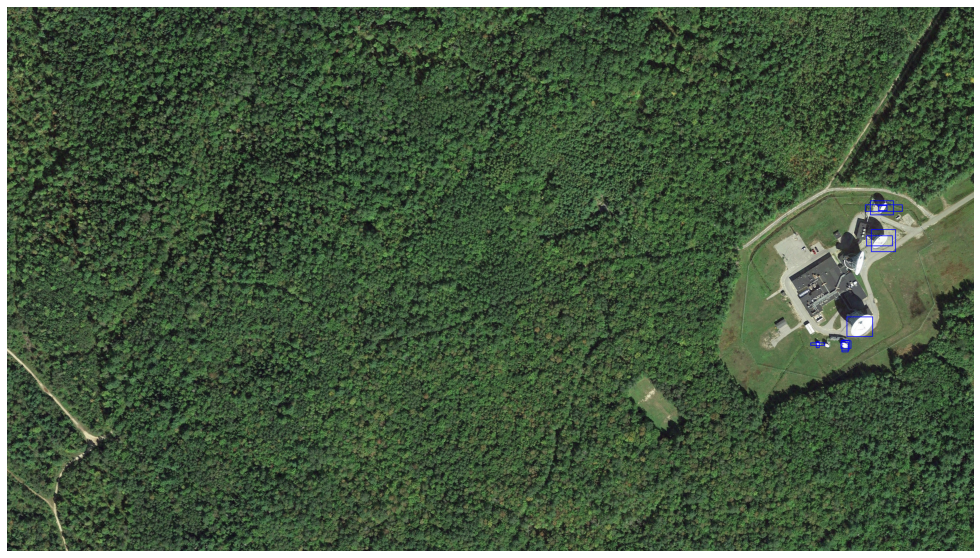

In [24]:
# Check it out
bboxes = readJson(file_root)

# Now we can project them back to our 4k image
import cv2 as cv 
import matplotlib.pyplot as plt 

tar_img = cv.imread(source_img)
img_size = tar_img.shape

for bbox in bboxes:
    cv.rectangle(tar_img, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)

fig = plt.gcf()
fig.set_size_inches(18, 10)
plt.axis("off")
plt.imshow(cv.cvtColor(tar_img, cv.COLOR_BGR2RGB))
plt.show()